In [1]:
using Random, LargeMessageCollider, Flux.Optimise, Distributions, Plots

┌ Info: Precompiling LargeMessageCollider [7f03d5f0-357e-4842-abc9-7001c0bc8a0e]
└ @ Base loading.jl:1278
┌ Warning: Package LargeMessageCollider does not have Random in its dependencies:
│ - If you have LargeMessageCollider checked out for development and have
│   added Random as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with LargeMessageCollider
└ Loading Random into LargeMessageCollider from project dependency, future warnings for LargeMessageCollider are suppressed.


In [357]:
Random.seed!(123);
N = 5;

In [358]:
inputs = [-5., -0.2, 3., 15., 6.]

5-element Array{Float64,1}:
 -5.0
 -0.2
  3.0
 15.0
  6.0

In [359]:
perturbations = rand(Normal(0,2),N)

5-element Array{Float64,1}:
  2.3805357619725536
  4.09635941557848
  2.285301805734398
  0.9188312408141607
 -0.793358158590446

In [360]:
sensor_inputs = inputs .+ perturbations

5-element Array{Float64,1}:
 -2.6194642380274464
  3.8963594155784795
  5.285301805734398
 15.91883124081416
  5.206641841409554

In [361]:
sensor_outputs = zeros(N)
for n=1:N
    sensor_outputs[n] = rand(truncated(Normal(sensor_inputs[n],0.5), 0., 10.))
end

In [362]:
sensor_outputs

5-element Array{Float64,1}:
 0.08531119988226044
 3.8586178823796016
 5.422209491340476
 9.995321137672626
 4.784702880686019

In [363]:
# initial messages
w_forw = Gamma(5,1) # Prior for w
x_back = [] # Initial backward messages from f_x
for n=1:N
    push!(x_back,Gamma(0.01,100))
end

In [364]:
m_fx = w_forw
for n=1:N
    m_fx = collide(m_fx,x_back[n])
end

In [365]:
m_fx

Gamma{Float64}(α=0.04999999999999938, θ=0.9523809523809523)

In [366]:
# Inference
q_x = []
q_w = w_forw
for iter=1:5000
    # Inference for x
    for i=1:N
        # Calculate the message towards fx_i
        m_fx = w_forw
        for n=1:N
            if n != i
                m_fx = collide(m_fx,x_back[n])
            end
        end
        # Calculate the forward message towards x_i
        mx_forw = normal(nothing,inputs[i],m_fx)
        if iter == 1 push!(q_x,mx_forw) end
        log_mx_forw(x) = logpdf(mx_forw,x)
        log_mx_back(x) = logpdf(truncated(Normal(x,0.5), 0., 10.),sensor_outputs[i])
        # Stochastic optimization
        for t=1:1
            η = [q_x[i].μ, q_x[i].σ, q_x[i].ν]
            ∇ = fegradient(q_x[i], log_mx_forw, log_mx_back)
            #η .-= 0.1/t * ∇
            η .-= 0.1/iter * ∇
            if η[2] < 0 η[2] = 0.01 end
            q_x[i] = Student(η[1], η[2], η[3])
        end
        x_back[i] = normal(q_x[i],inputs[i],nothing)
    end
    # Inference for w
    η = convert(Canonical,q_w).η
    q_w_mult = w_forw
    for n=1:N
        q_w_mult = collide(q_w_mult,x_back[n])
    end
    η_mult = convert(Canonical,q_w_mult).η
    ∇ = η .- η_mult
    η .-= 0.1/iter * ∇
    q_w = convert(Gamma,η)
end

In [367]:
q_x

5-element Array{Any,1}:
 Student(μ=-5.117804519526975, σ=1.585339926793215, ν=3.1970745242855267)
 Student(μ=2.8657517933203005, σ=3.9682715821287085, ν=5.900945489509776)
 Student(μ=5.092499867023533, σ=3.0744413111706623, ν=8.34924526605114)
 Student(μ=15.021775894733986, σ=1.4546176763166856, ν=11.045796052743098)
 Student(μ=5.246625048969601, σ=1.0937973223454998, ν=14.032743893850721)

In [368]:
q_w

Gamma{Float64}(α=6.501812182772604, θ=0.055814513352514)

In [369]:
mean(q_w)

0.36289548289089973

In [370]:
sensor_inputs

5-element Array{Float64,1}:
 -2.6194642380274464
  3.8963594155784795
  5.285301805734398
 15.91883124081416
  5.206641841409554

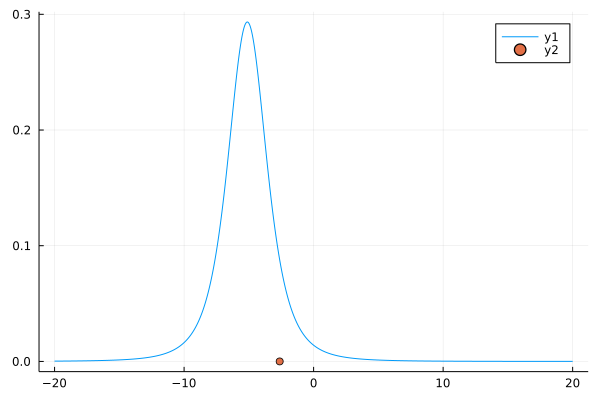

In [380]:
x_ax = collect(-20:0.01:20)
plot(x_ax,pdf.(q_x[1],x_ax))
scatter!((sensor_inputs[1],0))

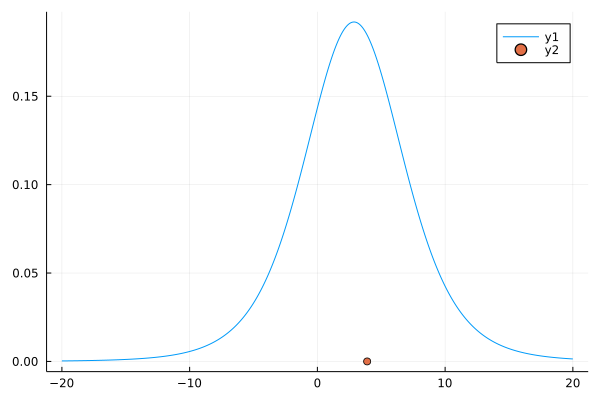

In [379]:
x_ax = collect(-20:0.01:20)
plot(x_ax,pdf.(q_x[2],x_ax))
scatter!((sensor_inputs[2],0))

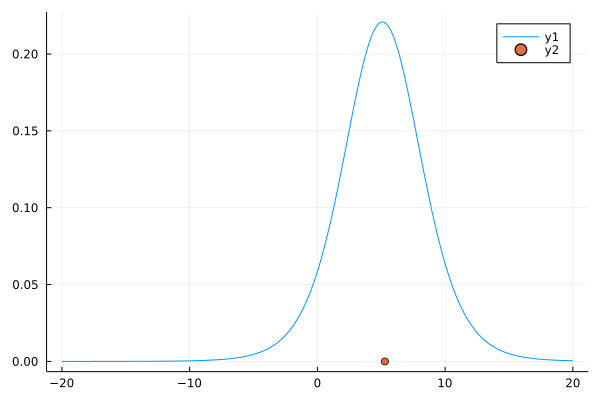

In [378]:
x_ax = collect(-20:0.01:20)
plot(x_ax,pdf.(q_x[3],x_ax))
scatter!((sensor_inputs[3],0))

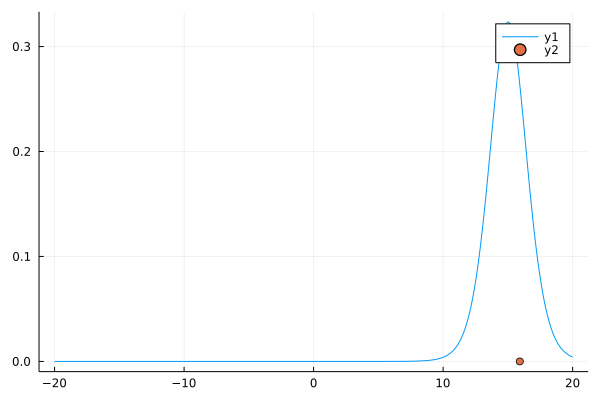

In [377]:
x_ax = collect(-20:0.01:20)
plot(x_ax,pdf.(q_x[4],x_ax))
scatter!((sensor_inputs[4],0))

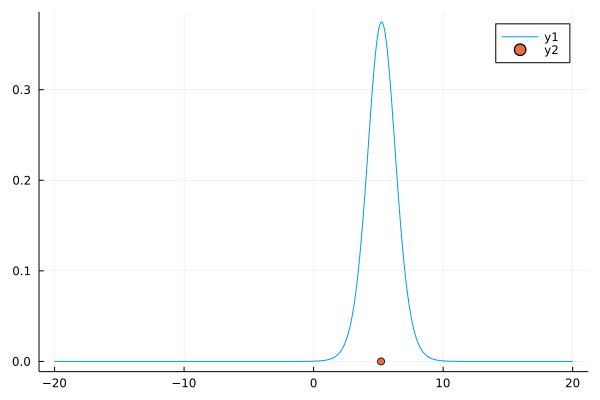

In [376]:
x_ax = collect(-20:0.01:20)
plot(x_ax,pdf.(q_x[5],x_ax))
scatter!((sensor_inputs[5],0))